## Imports and Train Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
import re
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer,AdamW, BertConfig,BertForSequenceClassification,get_linear_schedule_with_warmup
import torch
import tensorflow as tf
import random



In [3]:
train=pd.read_csv('Data/train.csv')
print(train.shape)
train.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Exploratory Data Analysis

### Nulls

In [4]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Keyword and location have null, so we replace them with "None"

In [5]:
train.fillna('None',inplace=True)
train.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

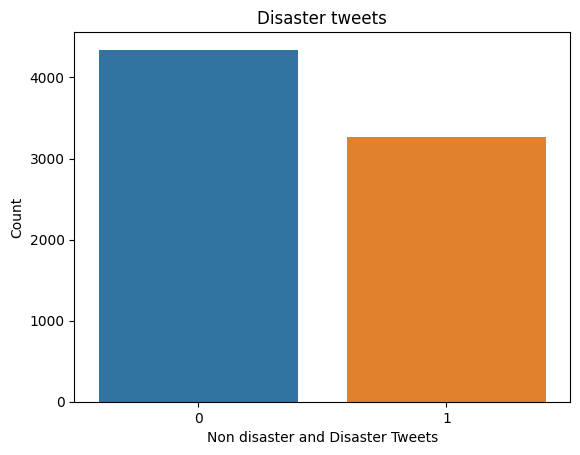

In [6]:
ax=sns.barplot(x='target',y='Count',data=train.groupby('target').agg({'id':'count'}).reset_index().rename(columns={'id':'Count'}))
ax.set_title('Disaster tweets')
ax.set_xlabel("Non disaster and Disaster Tweets")
plt.show()

Less than the half of the tweets correspond to real disasters

### Locations

We search for the count of the disaster tweets based on the location in order to find if the nulls have some meaning

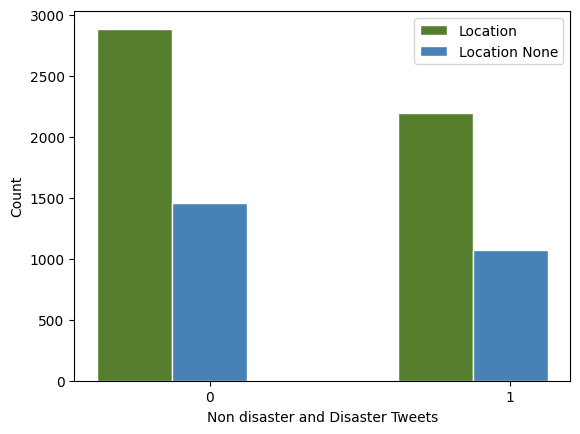

In [7]:
a=train[train.location!='None'].groupby('target').agg({'id':'count'}).reset_index().rename(columns={'id':'Cantidad'})
b=train[train.location=='None'].groupby('target').agg({'id':'count'}).reset_index().rename(columns={'id':'Cantidad'})
r1 = np.arange(len(a.Cantidad))
r2 = [x + 0.25 for x in r1]

plt.bar(r1, a.Cantidad, color='#557f2d', width=0.25, edgecolor='white', label='Location')
plt.bar(r2, b.Cantidad, color='steelblue', width=0.25, edgecolor='white', label='Location None')
plt.xlabel("Non disaster and Disaster Tweets")
plt.ylabel("Count")
plt.xticks([r + 0.25 for r in range(len(a.Cantidad))], [0,1])


plt.legend()
plt.show()

There is no difference between both distributions, so there should be no bias

Text(0.5, 1.0, 'Tweets per location')

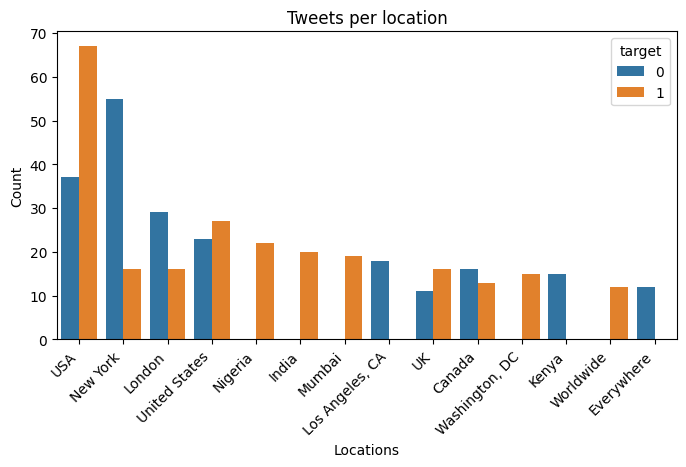

In [8]:
plt.figure(figsize=(8, 4))  # Ancho x Alto en pulgadas
sns.barplot(x='location',y='id',data=train[train.location!='None'].groupby(['location','target']).agg({'id':'count'}).reset_index().sort_values(['id','location'],ascending=False).head(20),hue='target')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Locations')
plt.ylabel('Count')
plt.title('Tweets per location')


When a tweet comes from "USA" there are more chances that the tweet indicates a real disaster, and it happens the other way around when it comes from "New York"

### Keywords

We analize the keywords from each tweet, discarding the "None" values

Text(0.5, 1.0, 'Gráfico tweets por location')

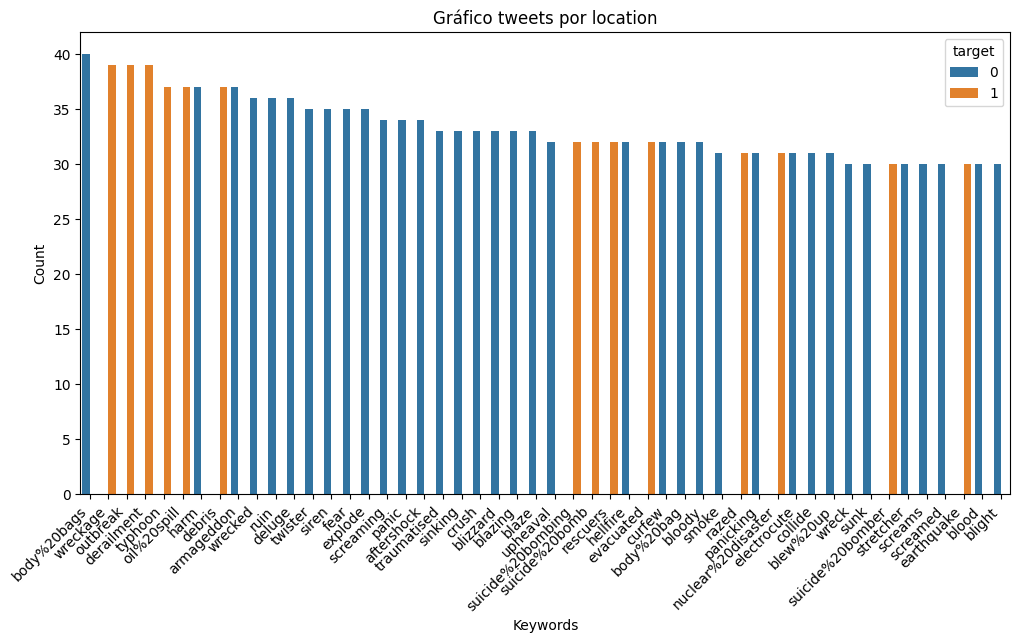

In [9]:
plt.figure(figsize=(12, 6))  
sns.barplot(x='keyword',y='id',data=train[train.keyword!='None'].groupby(['keyword','target']).agg({'id':'count'}).reset_index().sort_values(['id','keyword'],ascending=False).head(50),hue='target')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Keywords')
plt.ylabel('Count')
plt.title('Gráfico tweets por location')

In [10]:
train.keyword.value_counts()

None                     61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

## Feature Engineering

We analyze the distribution of the number of words per tweet and number of characters

<AxesSubplot: xlabel='num_words', ylabel='Count'>

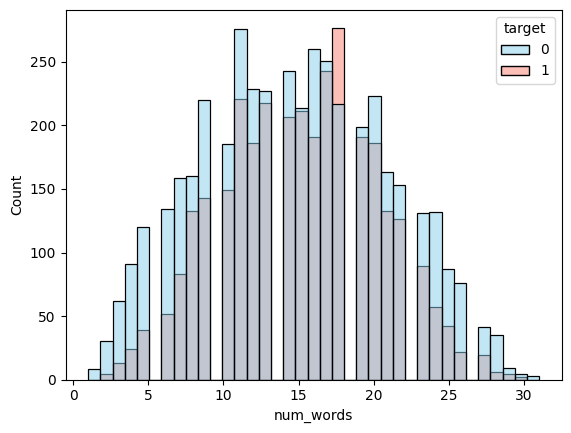

In [11]:
# Number of words
train['num_words']=train.text.apply(lambda x:len(x.split()))
sns.histplot(data=train,x='num_words',hue='target',palette=['skyblue','salmon'] )

Generalmente los tweets con menor cantidad de palabras no implican un desastre real

<AxesSubplot: xlabel='num_characters', ylabel='Count'>

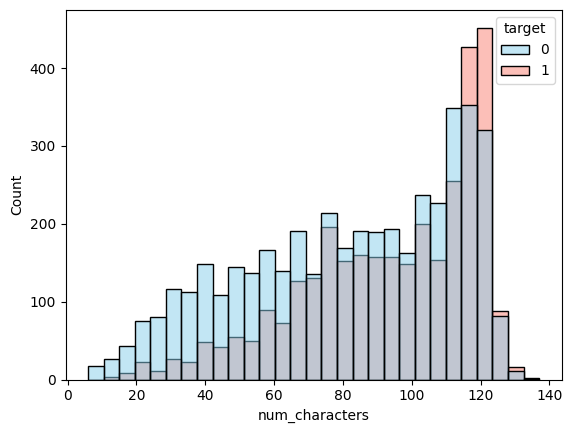

In [12]:
# Cantidad de caracteres
train['num_characters']=train.text.apply(lambda x:sum([len(z) for z in x.split()]))
sns.histplot(data=train,x='num_characters',hue='target',palette=['skyblue','salmon'] )

### Preprocessing

In [13]:
stopwords_eng=set(stopwords.words('english'))

def remove_stopword(text):
    text=[x for x in text.split() if x.lower() not in stopwords_eng]
    text=' '.join(text)
    text=text.lower()
    return text

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punctuation(text):
    punc = re.compile('[%s]' % re.escape(string.punctuation))
    punc = punc.sub('', text)
    return punc
    
def preprocess(text):
    text=remove_URL(text)
    text=remove_html(text)
    text=remove_emoji(text)
    text=remove_punctuation(text)
    text=remove_stopword(text)
    return text

def sum_characters(text):
    num_chr=sum([len(z) for z in text.split()])
    return num_chr
    
def sum_words(text):
    num_words=len(text.split())
    return num_words

def count_words_appeareance(text,dictionary):
    for i in text.split():
        if i not in dictionary.keys():
            dictionary.setdefault(i,1)
        else:
            dictionary[i]+=1


In [14]:
train.text[198]

'Why is there an ambulance right outside my work'

In [15]:
preprocess(train.text[198])

'ambulance right outside work'

In [16]:
# Data preprocessing
prep_train=train
prep_train.text=prep_train.text.apply(lambda x:preprocess(x))
prep_train.num_words=prep_train.text.apply(lambda x:sum_words(x))
prep_train.num_characters=prep_train.text.apply(lambda x:sum_characters(x))

In [17]:
prep_train.head()

,id,keyword,location,text,target,num_words,num_characters
0,1,None,None,deeds reason earthquake may allah forgive us,1,7,38
1,4,None,None,forest fire near la ronge sask canada,1,7,31
2,5,None,None,residents asked shelter place notified officer...,1,11,78
3,6,None,None,13000 people receive wildfires evacuation orde...,1,7,53
4,7,None,None,got sent photo ruby alaska smoke wildfires pou...,1,9,47


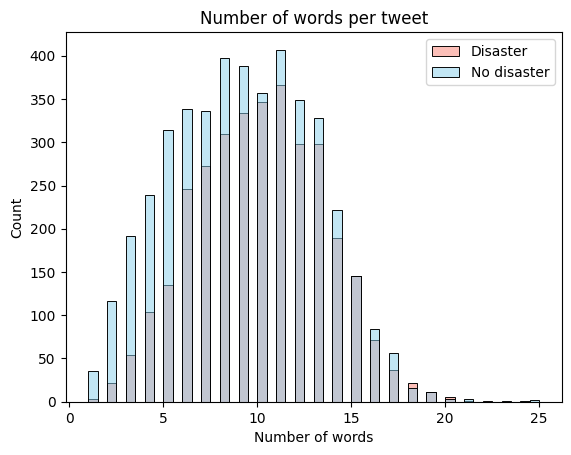

In [18]:
ax=sns.histplot(data=prep_train,x='num_words',hue='target',palette=['skyblue','salmon'] )
ax.set_title('Number of words per tweet')
ax.set_xlabel('Number of words')
ax.legend(['Disaster','No disaster'])

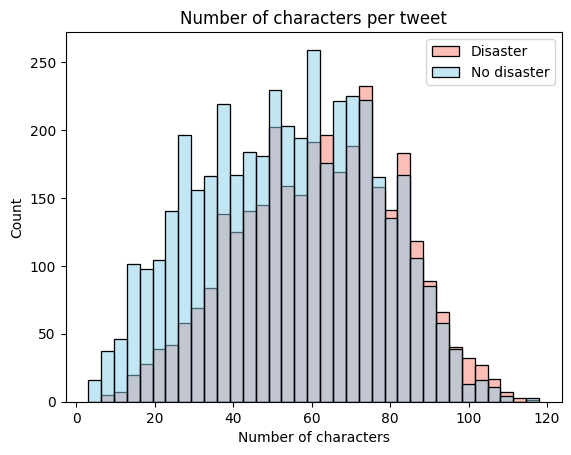

In [19]:
ax=sns.histplot(data=prep_train,x='num_characters',hue='target',palette=['skyblue','salmon'] )
ax.set_title('Number of characters per tweet')
ax.set_xlabel('Number of characters')
ax.legend(['Disaster','No disaster'])

In [20]:
# Words appearance in disaster and non disaster tweets
target_0=dict()
target_1=dict()
prep_train[prep_train.target==0].text.apply(lambda x:count_words_appeareance(x,target_0))
prep_train[prep_train.target==1].text.apply(lambda x:count_words_appeareance(x,target_1))
target_0_df=pd.DataFrame(list(target_0.items()), columns=['Word', 'Count'])
target_1_df=pd.DataFrame(list(target_1.items()), columns=['Word', 'Count'])

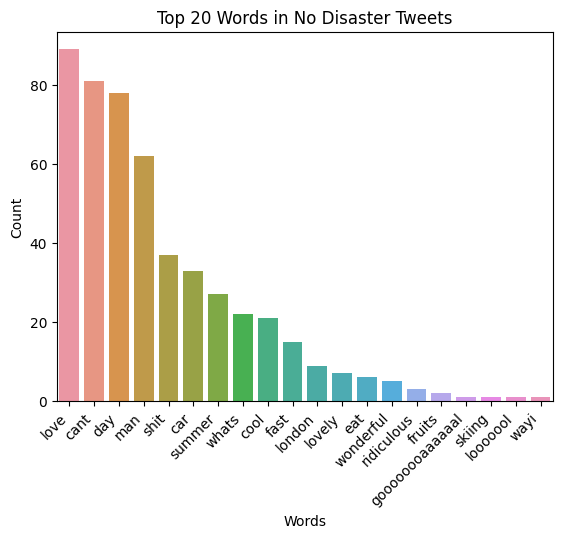

In [21]:
ax=sns.barplot(data=target_0_df.head(20).sort_values(by='Count',ascending=False),x='Word',y='Count')
ax.set_title('Top 20 Words in No Disaster Tweets')
ax.set_xlabel('Words')
plt.xticks(rotation=45, ha='right')
plt.show()

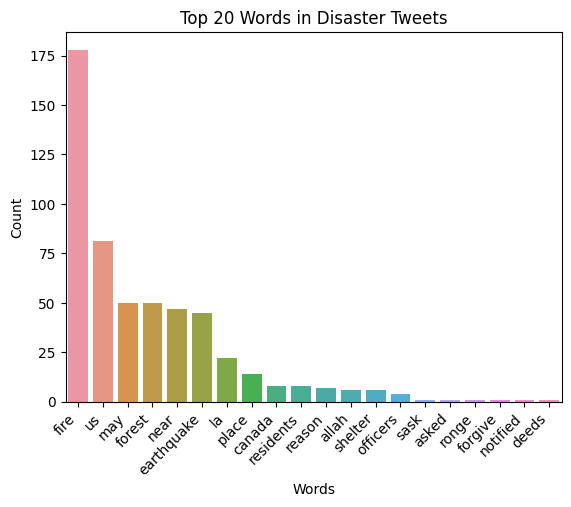

In [22]:
ax=sns.barplot(data=target_1_df.head(20).sort_values(by='Count',ascending=False),x='Word',y='Count')
ax.set_title('Top 20 Words in Disaster Tweets')
ax.set_xlabel('Words')
plt.xticks(rotation=45, ha='right')
plt.show()

In [23]:
### Ideas

# Vectorizar las palabras, escalarlas y sacar la clasificacion
# Vectorizar las oraciones

## Models

### TF-IDF y Random Forest

Accuracy: 0.771891418563923
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1318
           1       0.77      0.66      0.71       966

    accuracy                           0.77      2284
   macro avg       0.77      0.76      0.76      2284
weighted avg       0.77      0.77      0.77      2284



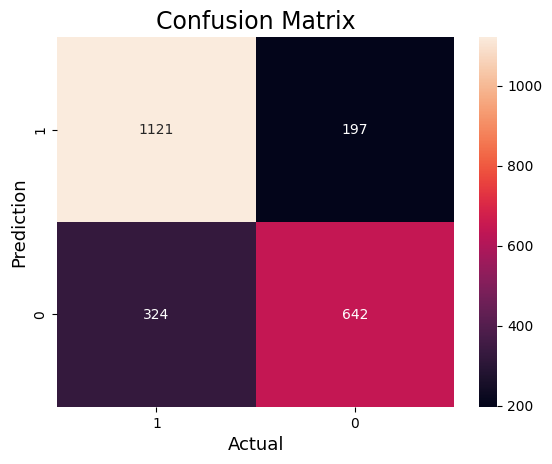

In [24]:
# Division de datos en train y validation
X_train, X_val, y_train, y_val = train_test_split(prep_train.text, prep_train.target, test_size=0.3, random_state=42)
X_train=[text for text in X_train]
X_val=[text for text in X_val]

# Vectorizador
vectorizer = TfidfVectorizer()
X_train_embedding = vectorizer.fit_transform(X_train) 
X_val_embedding = vectorizer.transform(X_val)         

# Entrenar RandomForest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_embedding, y_train)

# Predicciones
y_pred = clf.predict(X_val_embedding)

# Metricas
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

# Matriz de confusion
sns.heatmap(confusion_matrix(y_val, y_pred), 
            annot=True,
            fmt='g', 
            xticklabels=['1', '0'],
            yticklabels=['1', '0'])
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.show()


### Logistic Regression and TF-IFD

Accuracy: 0.8077933450087565
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1318
           1       0.83      0.68      0.75       966

    accuracy                           0.81      2284
   macro avg       0.81      0.79      0.80      2284
weighted avg       0.81      0.81      0.80      2284



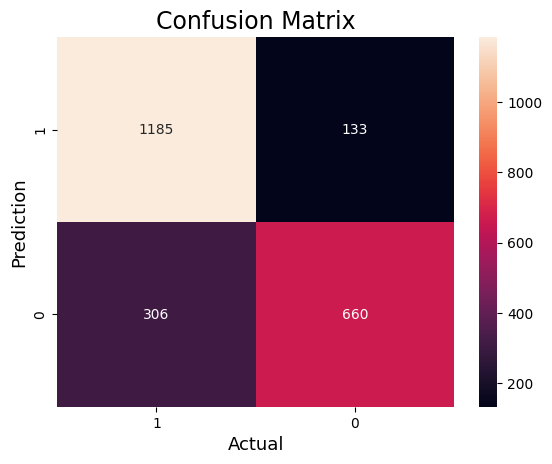

In [25]:
# Division de datos en train y validation
X_train, X_val, y_train, y_val = train_test_split(prep_train.text, prep_train.target, test_size=0.3, random_state=42)
X_train=[text for text in X_train]
X_val=[text for text in X_val]

# Vectorizador
vectorizer = TfidfVectorizer()
X_train_embedding = vectorizer.fit_transform(X_train) 
X_val_embedding = vectorizer.transform(X_val)         

# Entrenar RandomForest
clf = LogisticRegression(random_state=42)
clf.fit(X_train_embedding, y_train)

# Predicciones
y_pred = clf.predict(X_val_embedding)

# Metricas
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

# Matriz de confusion
sns.heatmap(confusion_matrix(y_val, y_pred), 
            annot=True,
            fmt='g', 
            xticklabels=['1', '0'],
            yticklabels=['1', '0'])
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.show()


### Logistic Regression and Word2Vec

In [26]:
# # Division de datos en train y validation
# X_train, X_val, y_train, y_val = train_test_split(prep_train.text, prep_train.target, test_size=0.3, random_state=42)
# X_train=[text for text in X_train]
# X_val=[text for text in X_val]

# # Vectorizador
# # Entrenamiento del modelo Word2Vec

# word2vec_model = Word2Vec(X_train,vector_size=100,window=5,min_count=1,sg=0)
     
# def document_vector(word2vec_model, doc):
#     # Filtrar palabras conocidas y calcular el promedio de vectores de palabras
#     words = [word for word in doc if word in word2vec_model.wv]
#     if len(words) > 0:
#         return np.mean(word2vec_model.wv[words], axis=0)
#     else:
#         return np.zeros(word2vec_model.vector_size)

# # Representación de textos de entrenamiento y validación como vectores Word2Vec
# X_train_embedding = np.array([document_vector(word2vec_model, doc) for doc in X_train])
# X_val_embedding = np.array([document_vector(word2vec_model, doc) for doc in X_val])

# # Entrenar RandomForest
# clf = LogisticRegression(random_state=42)
# clf.fit(X_train_embedding, y_train)

# # Predicciones
# y_pred = clf.predict(X_val_embedding)

# # Metricas
# accuracy = accuracy_score(y_val, y_pred)
# report = classification_report(y_val, y_pred)

# print(f"Accuracy: {accuracy}")
# print(f"Classification Report:\n{report}")

# # Matriz de confusion
# sns.heatmap(confusion_matrix(y_val, y_pred), 
#             annot=True,
#             fmt='g', 
#             xticklabels=['1', '0'],
#             yticklabels=['1', '0'])
# plt.ylabel('Prediction', fontsize=13)
# plt.xlabel('Actual', fontsize=13)
# plt.title('Confusion Matrix', fontsize=17)
# plt.show()

### Neural Network

c:\Users\Manuel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6052 - loss: 0.6766 - val_accuracy: 0.7417 - val_loss: 0.5920
Epoch 2/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8030 - loss: 0.5273 - val_accuracy: 0.8047 - val_loss: 0.4881
Epoch 3/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8914 - loss: 0.3690 - val_accuracy: 0.8065 - val_loss: 0.4515
Epoch 4/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9331 - loss: 0.2533 - val_accuracy: 0.7982 - val_loss: 0.4510
Epoch 5/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9477 - loss: 0.1946 - val_accuracy: 0.7947 - val_loss: 0.4629
Epoch 6/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9602 - loss: 0.1511 - val_accuracy: 0.7929 - val_loss: 0.4797
Epoch 7/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9678 - loss: 0.1221 - val_accuracy: 0.7863 - val_loss: 0.5008
Epoch 8/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9773 - loss: 0.0954 - val_accuracy: 0.

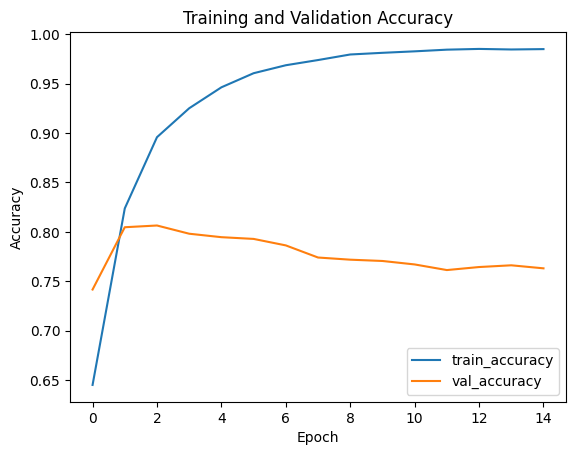

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7758318739054291
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82      1318
           1       0.78      0.65      0.71       966

    accuracy                           0.78      2284
   macro avg       0.78      0.76      0.76      2284
weighted avg       0.78      0.78      0.77      2284



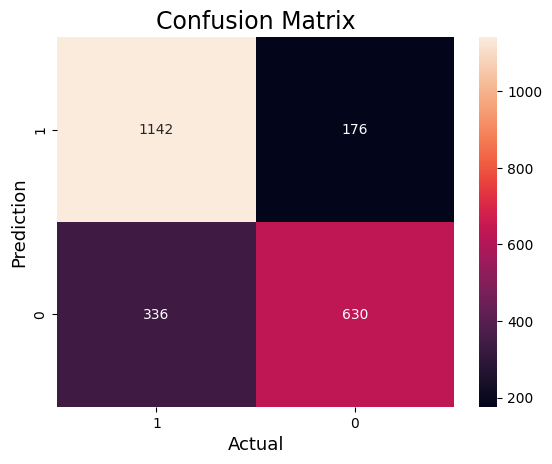

In [48]:
import tensorflow as tf
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Dividir los datos en train y validation
X_train, X_val, y_train, y_val = train_test_split(prep_train.text, prep_train.target, test_size=0.3, random_state=42)
X_train=[text for text in X_train]
X_val=[text for text in X_val]
# Vectorizador
vectorizer = TfidfVectorizer()
X_train_embedding = vectorizer.fit_transform(X_train) 
X_val_embedding = vectorizer.transform(X_val)

X_train_embedding=X_train_embedding.toarray()
X_val_embedding=X_val_embedding.toarray()

# Definir el modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8,activation='relu',input_shape=(X_train_embedding.shape[1],)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_embedding, y_train, epochs=15, batch_size=16, validation_data=(X_val_embedding, y_val))

# Visualizar la curva de pérdida y precisión
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred=model.predict(X_val_embedding)
y_pred = np.where(y_pred >= 0.7, 1, 0)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

# Matriz de confusion
sns.heatmap(confusion_matrix(y_val, y_pred), 
            annot=True,
            fmt='g', 
            xticklabels=['1', '0'],
            yticklabels=['1', '0'])
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.show()

### Bert

In [ ]:
#### Funciones Bert
def embed(sentences, y, tokenizer):
    input_ids = []
    attention_masks = []
    labels = y.values if y is not None else None

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=200,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    if labels is not None:
        labels = torch.tensor(labels) 
        prepared = torch.utils.data.TensorDataset(input_ids, attention_masks, labels)
    else:
        prepared = (input_ids, attention_masks) 
    return prepared

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train(train_dataloader, training_stats,model,optimizer, scheduler, device):
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("")
    print("Running Validation...")

    # Guardar estadísticas de entrenamiento
    training_stats.append({
        'avg_train_loss': avg_train_loss
    })

def evaluation(validation_dataloader,model, device):
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            loss = outputs.loss
            logits = outputs.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    return avg_val_accuracy, avg_val_loss

In [ ]:

# Codigo para usar GPU!!! 

# RIESGO DE MUERTE!

# # Get the GPU device name.
# device_name = tf.test.gpu_device_name()

# # The device name should look like the following:
# if device_name == '/device:GPU:0':
#     print('Found GPU at: {}'.format(device_name))
# else:
#     raise SystemError('GPU device not found')

# if torch.cuda.is_available():

#     # Tell PyTorch to use the GPU.
#     device = torch.device("cuda")

#     print('There are %d GPU(s) available.' % torch.cuda.device_count())

#     print('We will use the GPU:', torch.cuda.get_device_name(0))

# # If not...
# else:
#     print('No GPU available, using the CPU instead.')
#     device = torch.device("cpu")

In [ ]:
# Data split
X_train, X_val, y_train, y_val = train_test_split(prep_train.text, prep_train.target, test_size=0.3, random_state=42)
X_train=[text for text in X_train]
X_val=[text for text in X_val]

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Modelo
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,
    output_attentions = False, 
    output_hidden_states = False, 
)

# GPU.
model.cuda()

# Embeddings
prepared_train=embed(X_train,y_train,tokenizer)
prepared_val=embed(X_val,y_val,tokenizer)

# Data Loaders
train_loader=torch.utils.data.DataLoader(prepared_train, batch_size=32, shuffle=True, num_workers=4)
val_loader=torch.utils.data.DataLoader(prepared_val, batch_size=32, shuffle=True, num_workers=4)

# Optimizer
device = torch.device("cpu")
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
epochs = 2
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
# Train for epochs
training_stats = []
for epoch_i, _ in enumerate(range(epochs), start=1):
  print(f'-------------\nEpoch: {epoch_i:>2}/{epochs}')
  train(train_loader,training_stats,model,optimizer,scheduler,device)
  evaluation(val_loader,model, device)
  
# PREDICCION PARA NUEVOS TWEETS
sentences = [
    'There is a fire going on here in this place! It is chaos!!!',
    'Earthquake in USA, there were fatalities',
    'The movie was extremely good',
]
# Preprocesar las oraciones utilizando el tokenizador
input_ids, attention_masks = embed(sentences, y=None, tokenizer=tokenizer)

# Colocar los tensores en el dispositivo correcto
input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)

# Establecer el modelo en modo de evaluación
model.eval()

# Realizar la inferencia con el modelo
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_masks)

# Obtener las predicciones de clase
logits = outputs.logits
predicted_classes = torch.argmax(logits, dim=1).tolist()

# Imprimir las predicciones para cada oración
for i, sent in enumerate(sentences):
    if predicted_classes[i] == 1:
        print(f"{sent}': ES UN DESASTRE REAL")
    else:
        print(f"{sent}': NO ES UN DESASTRE REAL")

### New prediction

In [28]:
new_tweet='There is a fire going on here in this place! It is chaos!!!'
new_tweet=preprocess(new_tweet)
print(new_tweet)
new_tweet_vector = vectorizer.transform([new_tweet])

# Realización de la predicción utilizando el clasificador entrenado
prediction = clf.predict(new_tweet_vector)

print("Predicción:", prediction)


fire going place chaos
Predicción: [1]


## Test

In [29]:
""" # Test
test=pd.read_csv('test.csv')
test.text=test.text.apply(lambda x:preprocess(x))
X_test=[text for text in test.text]
X_test=vectorizer.transform(X_test)
prediction = clf.predict(X_test)
print("Predicción:", prediction) """

' # Test\ntest=pd.read_csv(\'test.csv\')\ntest.text=test.text.apply(lambda x:preprocess(x))\nX_test=[text for text in test.text]\nX_test=vectorizer.transform(X_test)\nprediction = clf.predict(X_test)\nprint("Predicción:", prediction) '

In [39]:
max_len=0
for x in X_train:
    if len(x)>max_len:
        max_len=len(x)

max_len

138

In [41]:
list(X_train)[0]

'ashes 2015 australia\x89ûªs collapse trent bridge among worst history england bundled australia 60'

In [47]:
X_train.values[0]

'ashes 2015 australia\x89ûªs collapse trent bridge among worst history england bundled australia 60'

In [52]:
len(X_train)

5329